In [12]:
import cv2
from bovw import BOVW
import pandas
from typing import *
from PIL import Image
import matplotlib.pyplot as plt 
from main import Dataset, run_final_pipeline, run_BOVW_experiment
from IPython.display import clear_output

import pandas as pd
import numpy as np

import os
import random
import matplotlib.pyplot as plt
from utils import plot_imgs_at_idx, box_plot

Loading the data

In [13]:
print("Loading Train Dataset...")
data_train = Dataset(ImageFolder="../places_reduced/train")

print("Loading Test Dataset...")
data_test = Dataset(ImageFolder="../places_reduced/val")

Loading Train Dataset...
{'shopping and dining': 0, 'sports and leisure': 1, 'water_ice_snow': 2, 'mountains_hills_desert_sky': 3, 'workplace': 4, 'home or hotel': 5, 'forest_field_jungle': 6, 'industrial and construction': 7, 'houses_cabins_gardens_farms': 8, 'commercial buildings': 9, 'sports_fields': 10}
Loading Test Dataset...
{'shopping and dining': 0, 'sports and leisure': 1, 'water_ice_snow': 2, 'mountains_hills_desert_sky': 3, 'workplace': 4, 'home or hotel': 5, 'forest_field_jungle': 6, 'industrial and construction': 7, 'houses_cabins_gardens_farms': 8, 'commercial buildings': 9, 'sports_fields': 10}


#### Run the entire suit of tests and save them to final_experiment_results.csv

In [14]:
# run_final_pipeline(data_train, data_test) # Uncomment for delivery

#### Loading the results csv from previous executions

In [15]:
results = pandas.read_csv("final_experiment_results.csv")

#### Impact of feature count

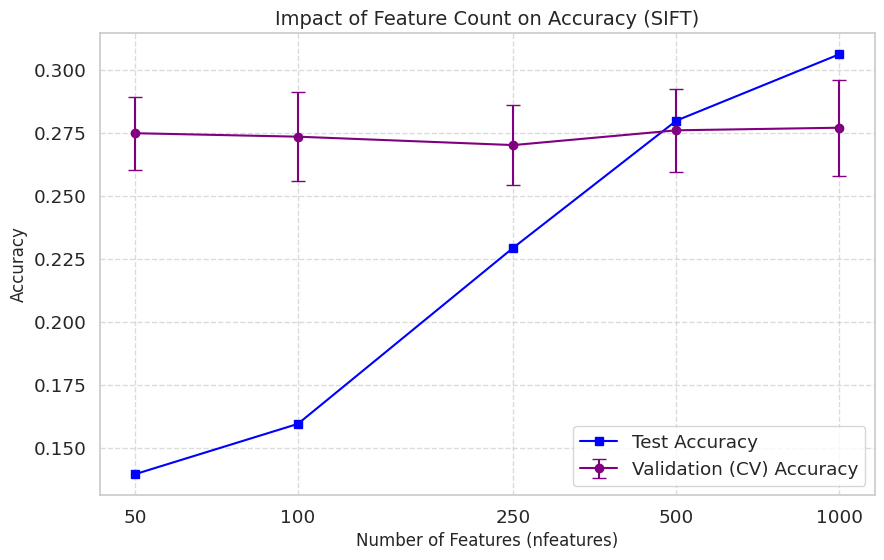

In [65]:

# Filter for Feature extraction
feature_exp = results[results["Experiment"] == "Feature Count"].copy()

# Convert 'Value' to int for proper plotting sorting
feature_exp["Value"] = feature_exp["Value"].astype(int)
feature_exp = feature_exp.sort_values("Value")
# Convert all accuracy and std columns to numeric for feature_exp
feature_exp["Train_Accuracy"] = pd.to_numeric(feature_exp["Train_Accuracy"], errors='coerce')
feature_exp["CV_Accuracy"] = pd.to_numeric(feature_exp["CV_Accuracy"], errors='coerce')
feature_exp["CV_Std"] = pd.to_numeric(feature_exp["CV_Std"], errors='coerce')
feature_exp["Test_Accuracy"] = pd.to_numeric(feature_exp["Test_Accuracy"], errors='coerce')

# Now plot
plt.figure(figsize=(10, 6))
plt.errorbar(feature_exp["Value"], feature_exp["CV_Accuracy"], 
             yerr=feature_exp["CV_Std"], 
             fmt='-o', label='Validation (CV) Accuracy', capsize=5, color='purple')

# plot test acc
plt.plot(feature_exp["Value"], feature_exp["Test_Accuracy"], 
         '-s', label='Test Accuracy', color='blue')

plt.title("Impact of Feature Count on Accuracy (SIFT)", fontsize=14)
plt.xlabel("Number of Features (nfeatures)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xscale('log') # Log scale helps visualize the wide range (50 to 1000)
plt.xticks(feature_exp["Value"], feature_exp["Value"]) # Force show all ticks
plt.show()

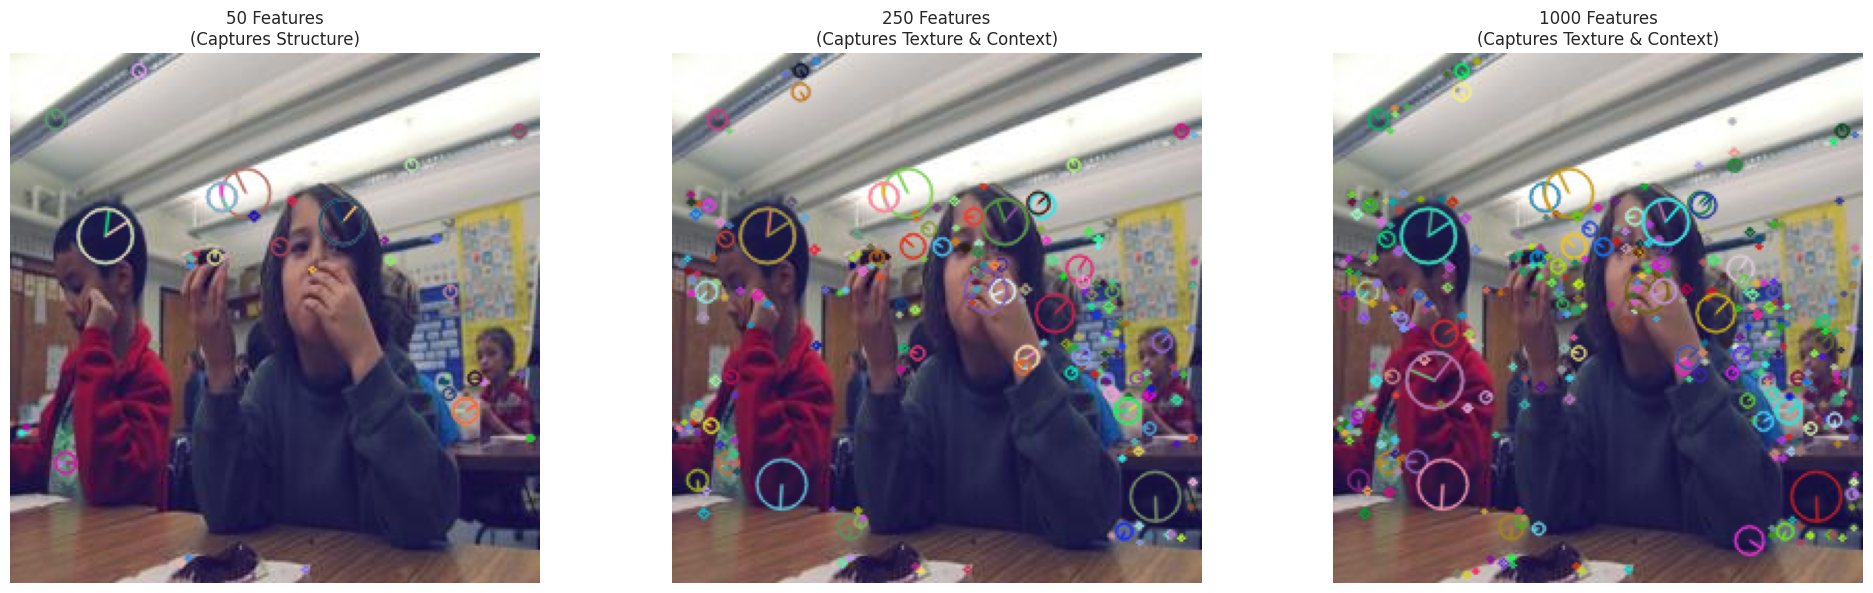

In [25]:

# Get a sample image
sample_img_pil, label = data_train[100] 
sample_img = np.array(sample_img_pil) 
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)


counts_to_show = [50, 250, 1000]
plt.figure(figsize=(20, 6))

for i, n in enumerate(counts_to_show):
    # Initialize SIFT with nfeatures
    sift = cv2.SIFT_create(nfeatures=n)
    keypoints = sift.detect(gray_img, None)
    
    # Draw keypoints
    # DRAW_RICH_KEYPOINTS shows the size and orientation of the feature
    img_kps = cv2.drawKeypoints(sample_img, keypoints, None, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(img_kps)
    plt.title(f"{n} Features\n(Captures {'Structure' if n<100 else 'Texture & Context'})")
    plt.axis('off')

plt.tight_layout()
plt.show()

Class Mapping (Index -> Name):
{0: 'shopping and dining', 1: 'sports and leisure', 2: 'water_ice_snow', 3: 'mountains_hills_desert_sky', 4: 'workplace', 5: 'home or hotel', 6: 'forest_field_jungle', 7: 'industrial and construction', 8: 'houses_cabins_gardens_farms', 9: 'commercial buildings', 10: 'sports_fields'}


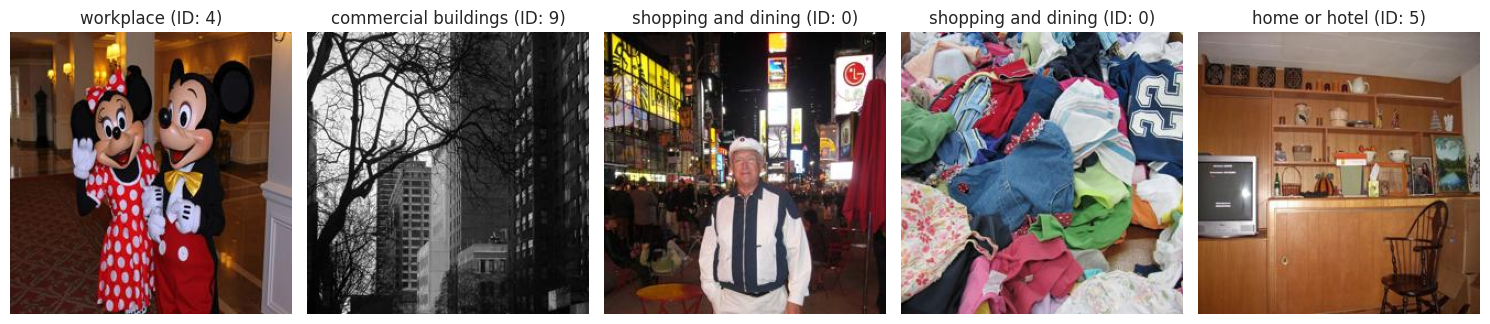

In [27]:


# print all the class labels
train_folder = "../places_reduced/train"
class_names = os.listdir(train_folder)
idx_to_class = {idx: name for idx, name in enumerate(class_names)}

print("Class Mapping (Index -> Name):")
print(idx_to_class)

# 2. Visualize Random Samples
num_samples = 5
random_indices = random.sample(range(len(data_train)), num_samples)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, label_idx = data_train[idx]
    label_name = idx_to_class.get(label_idx, "Unknown")
    
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f"{label_name} (ID: {label_idx})")
    plt.axis("off")

plt.tight_layout()
plt.show()

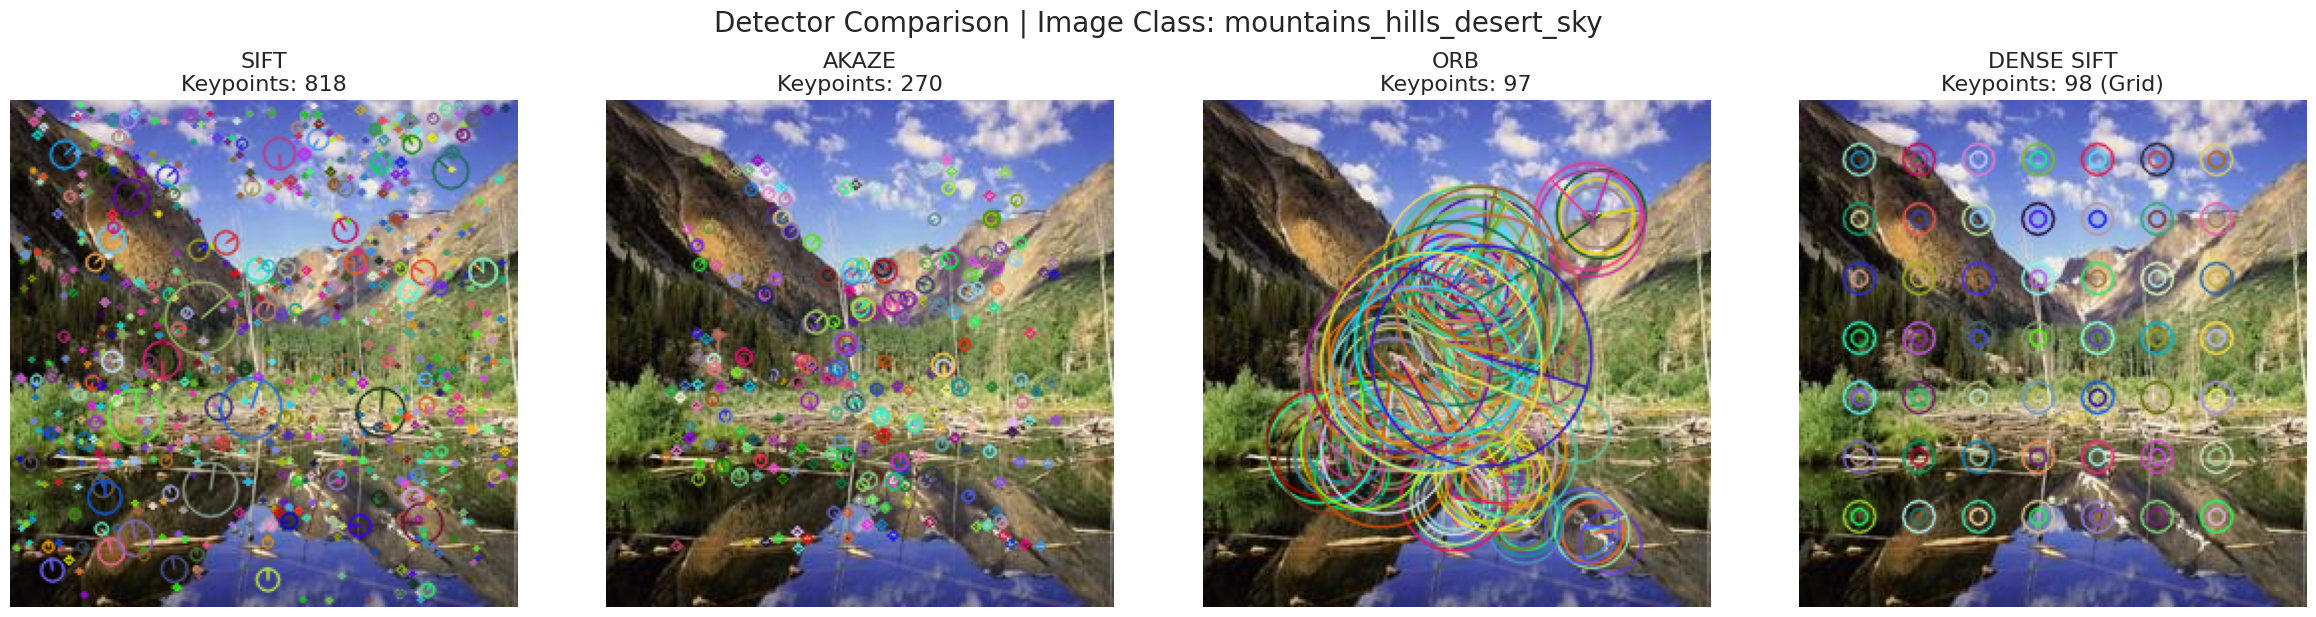

In [28]:

# select a random image from dataset
idx = random.randint(0, len(data_train)-1)
sample_img_pil, label_idx = data_train[idx]
sample_img = np.array(sample_img_pil)
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

# Get class name for the title
class_name = idx_to_class.get(label_idx, "Unknown")

# 2. Define the Detectors
detectors = {
    "SIFT": cv2.SIFT_create(), # Default (usually finds ~500-2000)
    "AKAZE": cv2.AKAZE_create(),          # Default (excellent for edges)
    
    # FIX: Reduce nfeatures for ORB to avoid the "messy blob" effect
    # We lower it to 400 so it picks only the very best corners for the slide
    "ORB": cv2.ORB_create(nfeatures=100, scoreType=cv2.ORB_HARRIS_SCORE), 
}

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle(f"Detector Comparison | Image Class: {class_name}", fontsize=20, y=1.02)

#  Run Standard Detectors
for i, (name, detector) in enumerate(detectors.items()):
    # Detect
    kps = detector.detect(gray_img, None)
    
    img_draw = cv2.drawKeypoints(sample_img, kps, None, 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    axes[i].imshow(img_draw)
    axes[i].set_title(f"{name}\nKeypoints: {len(kps)}", fontsize=16)
    axes[i].axis("off")

# Run DENSE SIFT 
step_size = 30 
scales = [8, 16]
dense_kps = []
h, w = gray_img.shape
for scale in scales:
    for y in range(step_size, h - step_size, step_size):
        for x in range(step_size, w - step_size, step_size):
            dense_kps.append(cv2.KeyPoint(float(x), float(y), float(scale)))

img_dense = cv2.drawKeypoints(sample_img, dense_kps, None, 
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

axes[3].imshow(img_dense)
axes[3].set_title(f"DENSE SIFT\nKeypoints: {len(dense_kps)} (Grid)", fontsize=16)
axes[3].axis("off")

plt.tight_layout()
plt.show()


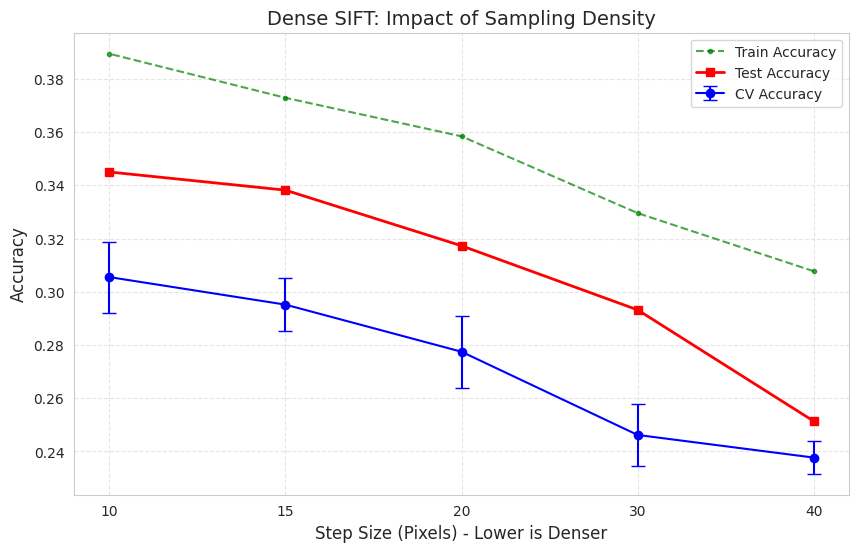

In [29]:

df = pd.read_csv("final_experiment_results.csv")

# 2. Filter for Dense SIFT Step (Density Analysis)
step_data = df[df["Experiment"] == "Dense SIFT Step"].copy()
step_data["Value"] = pd.to_numeric(step_data["Value"])
step_data = step_data.sort_values("Value", ascending=False) # 40 -> 10

# 3. Plotting
plt.figure(figsize=(10, 6))

# Line 1: Training Accuracy (Shows learning capacity)
plt.plot(step_data["Value"].astype(str), step_data["Train_Accuracy"], 
         '--.', label='Train Accuracy', color='green', alpha=0.7)

# Line 2: CV Accuracy (Shows expected generalization)
plt.errorbar(step_data["Value"].astype(str), step_data["CV_Accuracy"], 
             yerr=step_data["CV_Std"], fmt='-o', label='CV Accuracy', color='blue', capsize=5)

# Line 3: Test Accuracy (Real-world performance)
plt.plot(step_data["Value"].astype(str), step_data["Test_Accuracy"], 
         '-s', label='Test Accuracy', color='red', linewidth=2)

plt.title("Dense SIFT: Impact of Sampling Density", fontsize=14)
plt.xlabel("Step Size (Pixels) - Lower is Denser", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis() # Show Sparse -> Dense

plt.show()

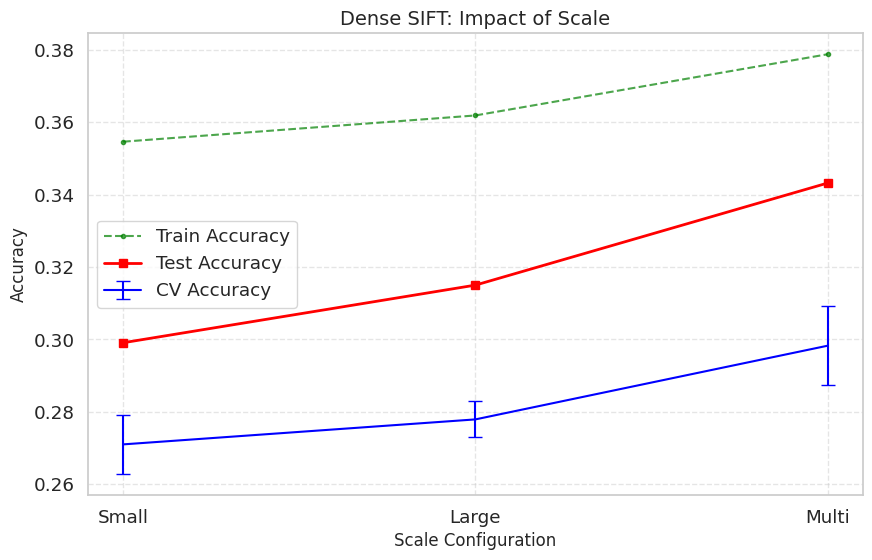

In [64]:

# Filter for Dense SIFT Scales
scale_data = results[results["Experiment"] == "Dense SIFT Scales"].copy()

# Manually order the categorical x-axis
order = ["Small", "Large", "Multi"]
scale_data["Value"] = pd.Categorical(scale_data["Value"], categories=order, ordered=True)
scale_data = scale_data.sort_values("Value")
# Convert all accuracy and std columns to numeric
scale_data["Train_Accuracy"] = pd.to_numeric(scale_data["Train_Accuracy"], errors='coerce')
scale_data["CV_Accuracy"] = pd.to_numeric(scale_data["CV_Accuracy"], errors='coerce')
scale_data["CV_Std"] = pd.to_numeric(scale_data["CV_Std"], errors='coerce')
scale_data["Test_Accuracy"] = pd.to_numeric(scale_data["Test_Accuracy"], errors='coerce')

# Now plot
plt.figure(figsize=(10, 6))
plt.plot(scale_data["Value"], scale_data["Train_Accuracy"], '--.', label='Train Accuracy', color='green', alpha=0.7)
plt.errorbar(scale_data["Value"], scale_data["CV_Accuracy"], 
             yerr=scale_data["CV_Std"], label='CV Accuracy', color='blue', capsize=5)
plt.plot(scale_data["Value"], scale_data["Test_Accuracy"], 
         '-s', label='Test Accuracy', color='red', linewidth=2)
plt.title("Dense SIFT: Impact of Scale", fontsize=14)
plt.xlabel("Scale Configuration", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

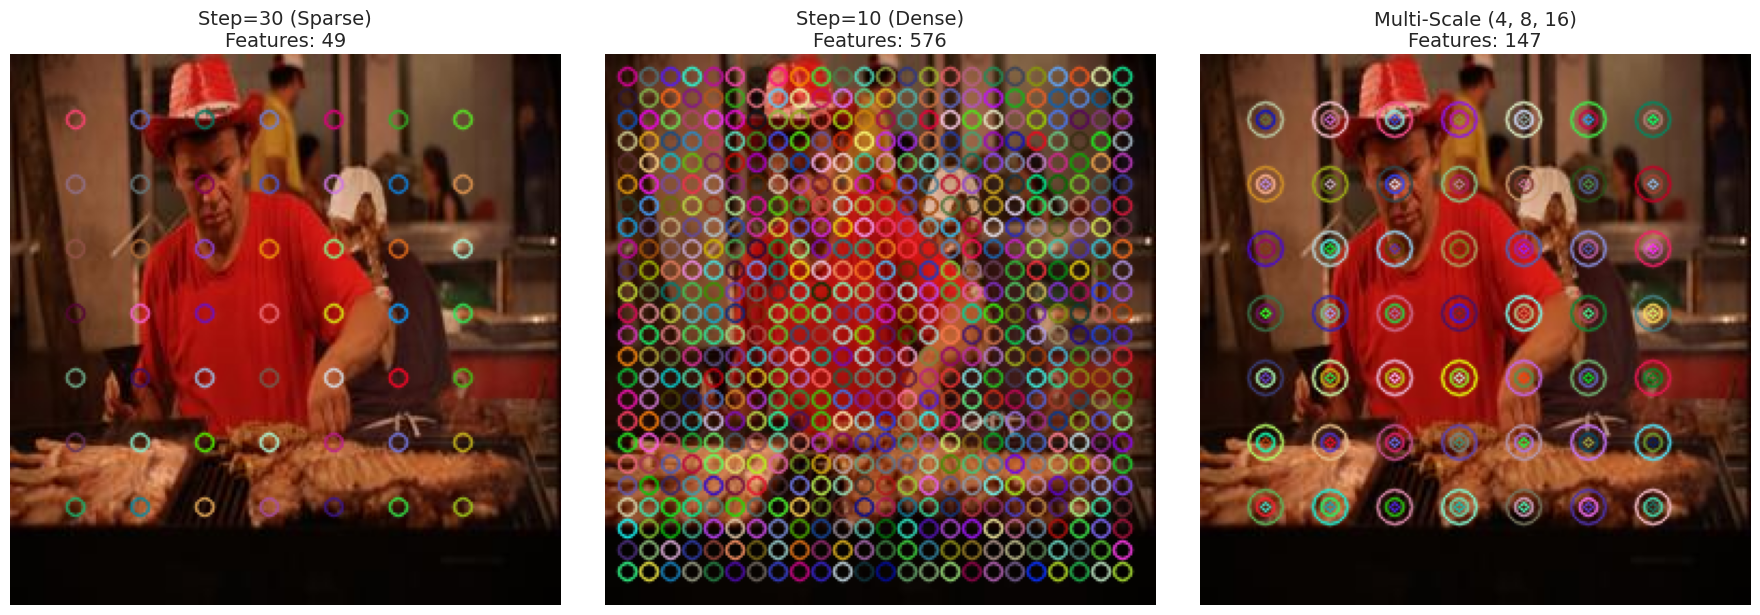

In [31]:


# Pick a random image
idx = random.randint(0, len(data_train)-1)
sample_img_pil, _ = data_train[idx]
sample_img = np.array(sample_img_pil)
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
h, w = gray_img.shape

# Helper to generate grid keypoints
def get_dense_kps(step, scales):
    kps = []
    for scale in scales:
        for y in range(step, h - step, step):
            for x in range(step, w - step, step):
                kps.append(cv2.KeyPoint(float(x), float(y), float(scale)))
    return kps

configs = [
    {"name": "Step=30 (Sparse)", "step": 30, "scales": [8]},
    {"name": "Step=10 (Dense)", "step": 10, "scales": [8]},
    {"name": "Multi-Scale (4, 8, 16)", "step": 30, "scales": [4, 8, 16]}
]

plt.figure(figsize=(18, 6))

for i, cfg in enumerate(configs):
    kps = get_dense_kps(cfg["step"], cfg["scales"])
    
    # Draw (Rich keypoints show scale)
    img_draw = cv2.drawKeypoints(sample_img, kps, None, 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(img_draw)
    plt.title(f"{cfg['name']}\nFeatures: {len(kps)}", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

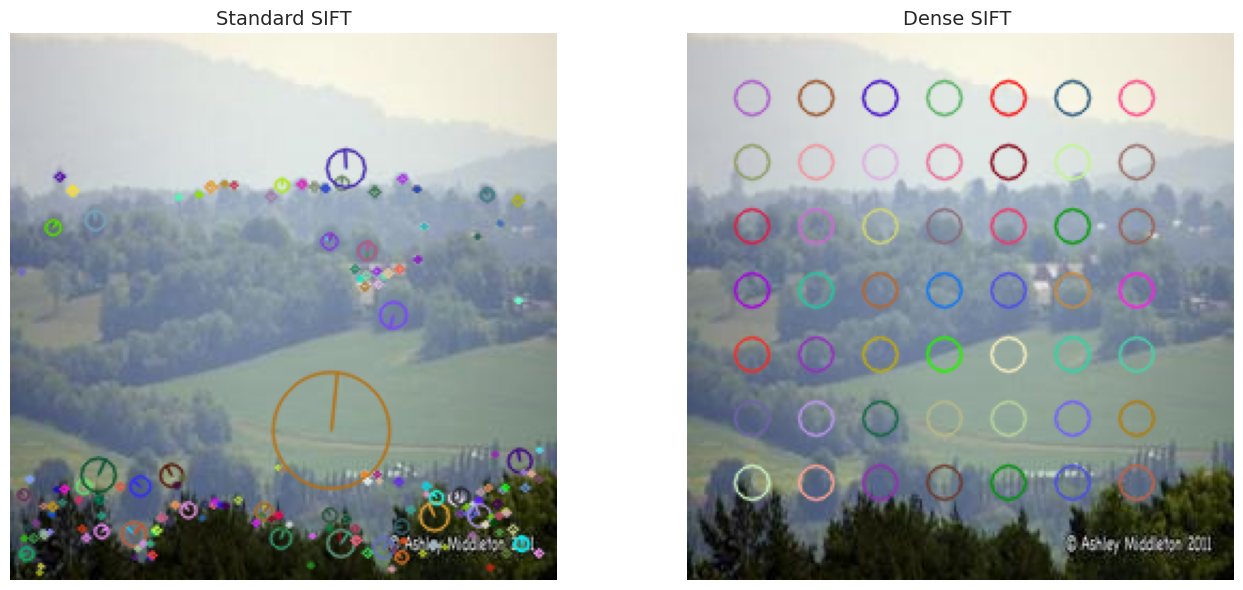

In [32]:

# Get a sample image
idx = random.randint(0, len(data_train)-1)
sample_img_pil, label_idx = data_train[idx]
sample_img = np.array(sample_img_pil)
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

# 2. Compare Standard vs Dense
# Standard SIFT
sift = cv2.SIFT_create()
kps_std = sift.detect(gray_img, None)
img_std = cv2.drawKeypoints(sample_img, kps_std, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Dense SIFT 
dense_kps = []
step = 30
h, w = gray_img.shape
for y in range(step, h-step, step):
    for x in range(step, w-step, step):
        dense_kps.append(cv2.KeyPoint(float(x), float(y), 16)) # Scale 16
img_dense = cv2.drawKeypoints(sample_img, dense_kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); plt.imshow(img_std); plt.title("Standard SIFT", fontsize=14); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img_dense); plt.title("Dense SIFT ", fontsize=14); plt.axis('off')
plt.tight_layout(); plt.show()

### Experiment: Effect of Codebook Size (k) on BoVW Performance



Value          CV_Accuracy        Test_Accuracy
14    32   0.2524677942799733   0.2777272727272727
15    64  0.26419450999054817   0.2722727272727273
16   128    0.272012386561176  0.30954545454545457
17   256   0.2710923175560006  0.30363636363636365
18   512   0.2748870073301475  0.29818181818181816

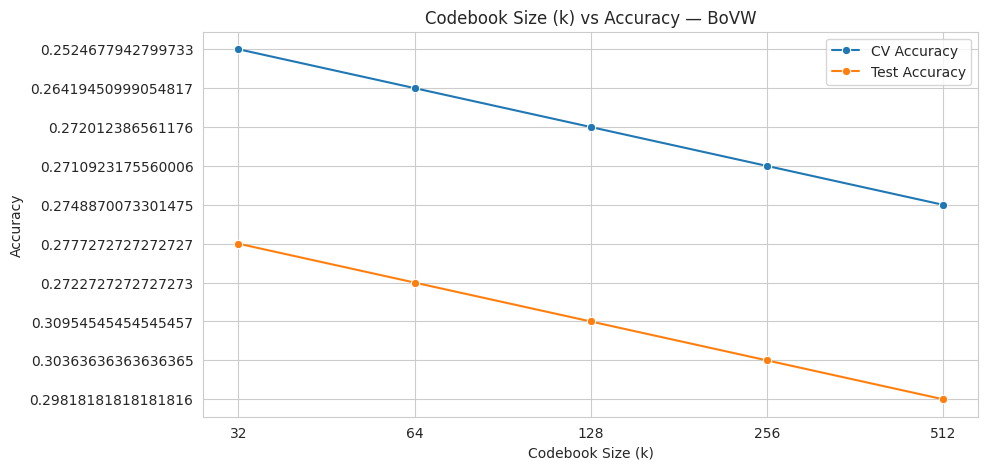

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

df_k = results[results["Experiment"] == "Codebook Size"].copy()


display(df_k[["Value", "CV_Accuracy", "Test_Accuracy"]])

plt.figure(figsize=(10,5))
sns.lineplot(x=df_k["Value"], y=df_k["CV_Accuracy"], marker="o", label="CV Accuracy")
sns.lineplot(x=df_k["Value"], y=df_k["Test_Accuracy"], marker="o", label="Test Accuracy")
plt.title("Codebook Size (k) vs Accuracy — BoVW")
plt.xlabel("Codebook Size (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()




In this experiment, we evaluate how changing the **codebook size** in the Bag-of-Visual-Words (BoVW) pipeline affects classification performance.

We observed:
- Small codebooks (k = 32–64) didn’t perform very well. They don’t capture enough variety in the image features.
- Medium sizes (k = 128) gave the best results. This is where the model captures enough detail without becoming too sparse.
- Large sizes (k = 256–512) didn’t really improve accuracy. The histograms become too sparse due to overfitting and the classifier benefits less.


### Qualitative Example: How Codebook Size Affects Predictions

To better understand the impact of codebook size on image classification, we compare predictions for a single test image across different values of **k**.

For each codebook size:
- We display the predicted class.
- We highlight correct predictions in **green** and incorrect ones in **red**.
- This helps visually analyze how increasing k affects model behavior on individual samples.

Experiment codebook succesfull


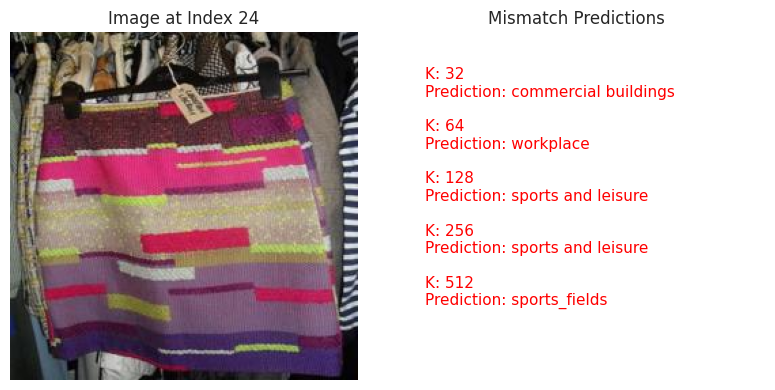

In [60]:

codebook_data_acc = {}
codebook_data = {}
codebook_sizes =  [32,64,128,256,512]
for codebook in codebook_sizes:
        bovw = BOVW(detector_type="SIFT", codebook_size=codebook)
        codebook_data_acc[codebook], codebook_data[codebook] = run_BOVW_experiment(bovw,data_train,data_test,)


clear_output()
print("Experiment codebook succesfull")

index = 24

plot_imgs_at_idx(index,data_test,codebook_sizes,codebook_data)



### Fisher Vector Performance Across GMM Components (K)

Here we examine how Fisher Vector performance changes with the number of **Gaussian Mixture Model (GMM)** components.

Key observations:
- Increasing K produces better, higher-dimensional Fisher Vectors.
- Both **cross-validation accuracy** and **test accuracy** are analyzed.
- FV generally performs better than BoVW and scales better with K.

This plot helps identify the point where adding more Gaussian components provides diminishing returns.

### BoVW vs Fisher Vectors — Accuracy Comparison

This visualization directly compares **BoVW test accuracy** with **Fisher Vector test accuracy** for matching values of K.

- BoVW uses K as the **number of visual words**.
- Fisher Vectors use K as the **number of GMM components**.
- A grouped bar chart shows which representation performs better at each K.

This combined comparison clearly highlights the performance gap and shows how Fisher Vectors outperform BoVW across nearly all values of k.


Loaded Fisher Vector results:


timestamp    detector    K  n_train_images  n_test_images  \
0  2025-12-05 19:04:33.331874  DENSE_SIFT   32            8700           2200   
1  2025-12-05 19:16:06.756453  DENSE_SIFT   64            8700           2200   
2  2025-12-05 19:32:32.226048  DENSE_SIFT  128            8700           2200   

   cv_mean_acc  cv_std_acc  test_acc  
0     0.310345    0.018946  0.355909  
1     0.322644    0.007320  0.371364  
2     0.333908    0.008955  0.375000


Best BoVW configuration:


Experiment               Codebook Size
Parameter                            k
Value                              128
Classifier                  svm_linear
Train_Accuracy     0.35525408139802256
CV_Accuracy          0.272012386561176
CV_Std            0.017625441458403935
Test_Accuracy                 0.309545
Name: 16, dtype: object

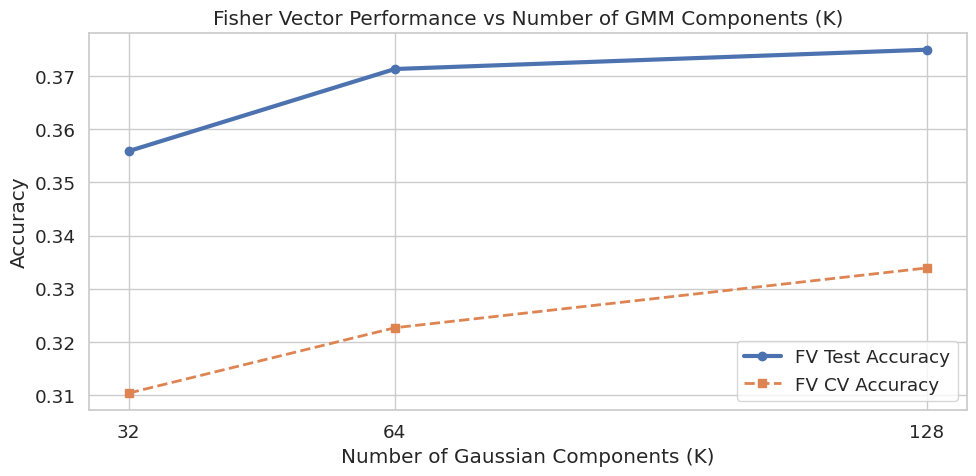

Merged Accuracy Table:


K        BoVW_Accuracy  FV_Accuracy
0   32   0.2777272727272727     0.355909
1   64   0.2722727272727273     0.371364
2  128  0.30954545454545457     0.375000
3  256  0.30363636363636365          NaN
4  512  0.29818181818181816          NaN

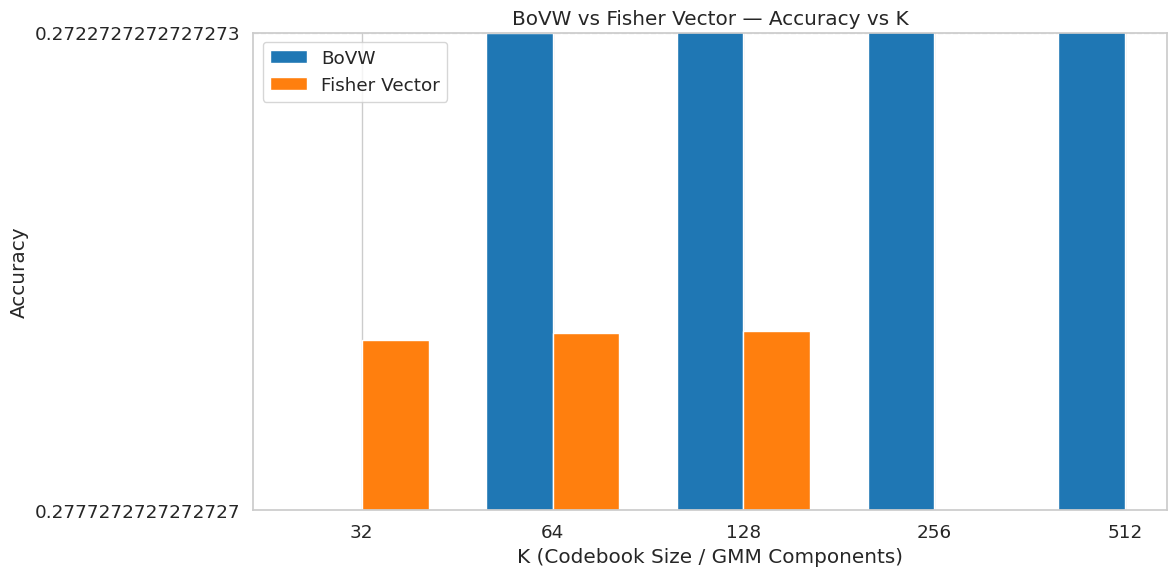

In [62]:
sns.set(style="whitegrid", font_scale=1.2)

# Load FV results
df_fv = pd.read_csv("fisher_vector_results.csv")
print("Loaded Fisher Vector results:")
display(df_fv)


# Load BoVW (Codebook Size) results for comparison
df_k = results[results["Experiment"] == "Codebook Size"].copy()


df_k["Test_Accuracy"] = pd.to_numeric(df_k["Test_Accuracy"], errors='coerce')

# Only test accuracy is needed for comparison
bovw_best = df_k.loc[df_k["Test_Accuracy"].idxmax()]
print("\nBest BoVW configuration:")
display(bovw_best)


# 1) Fisher Vector Trend Plot

plt.figure(figsize=(10,5))
plt.plot(df_fv["K"], df_fv["test_acc"], marker="o", linewidth=3, label="FV Test Accuracy")
plt.plot(df_fv["K"], df_fv["cv_mean_acc"], marker="s", linestyle="--", linewidth=2, label="FV CV Accuracy")

plt.title("Fisher Vector Performance vs Number of GMM Components (K)")
plt.xlabel("Number of Gaussian Components (K)")
plt.ylabel("Accuracy")
plt.xticks(df_fv["K"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Fisher Vector vs BoVW: Grouped Bar Plot (Accuracy vs K)


# Load FV and BoVW results

df_fv = pd.read_csv("fisher_vector_results.csv")
df_k = results[results["Experiment"] == "Codebook Size"].copy()


# Standardize column names

df_fv_small = df_fv[["K", "test_acc"]].rename(columns={"test_acc": "FV_Accuracy"})
df_bovw_small = df_k[["Value", "Test_Accuracy"]].rename(
    columns={"Value": "K", "Test_Accuracy": "BoVW_Accuracy"}
)


# Fix both Ks as integers

df_fv_small["K"] = pd.to_numeric(df_fv_small["K"], errors="coerce").astype("Int64")
df_bovw_small["K"] = pd.to_numeric(df_bovw_small["K"], errors="coerce").astype("Int64")


# Merge on K, outer join keeps all existing K values

df_merge = pd.merge(df_bovw_small, df_fv_small, on="K", how="outer").sort_values("K")

print("Merged Accuracy Table:")
display(df_merge)


# Plot: grouped bar chart

plt.figure(figsize=(12,6))

bar_width = 0.35
x = range(len(df_merge))

plt.bar(
    [p - bar_width/2 for p in x], 
    df_merge["BoVW_Accuracy"], 
    width=bar_width, 
    label="BoVW", 
    color="#1f77b4"
)

plt.bar(
    [p + bar_width/2 for p in x], 
    df_merge["FV_Accuracy"], 
    width=bar_width, 
    label="Fisher Vector", 
    color="#ff7f0e"
)

plt.xticks(x, df_merge["K"])
plt.xlabel("K (Codebook Size / GMM Components)")
plt.ylabel("Accuracy")
plt.title("BoVW vs Fisher Vector — Accuracy vs K")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Testint different Scaling methods, as well as normalization.

In [34]:
scaling_acc = {}
scaling_data = {}
methods =  ["None", "l2", "hellinger", "l1", "standard", "minmax"]
for method in methods:
        bovw = BOVW(detector_type="SIFT", codebook_size=128, method=method)
        scaling_acc[method], scaling_data[method] = run_BOVW_experiment(bovw,data_train,data_test,)


clear_output()
print("Experiment scaling succesfull")

Experiment scaling succesfull


In [35]:
import numpy as np
correct_guesses = {}
for method in methods:
    correct_guesses[method] =  [gt == pred for gt, pred in zip(scaling_data[method][1], scaling_data[method][0])]

No_Method = np.array(correct_guesses["None"])
S1 = np.array(correct_guesses["l2"])
S2 = np.array(correct_guesses["hellinger"])
S3 = np.array(correct_guesses["l1"])
S4 = np.array(correct_guesses["standard"])
S5 = np.array(correct_guesses["minmax"])

Lets find an image that we find with no scaling, but cant find with a certain scaling.

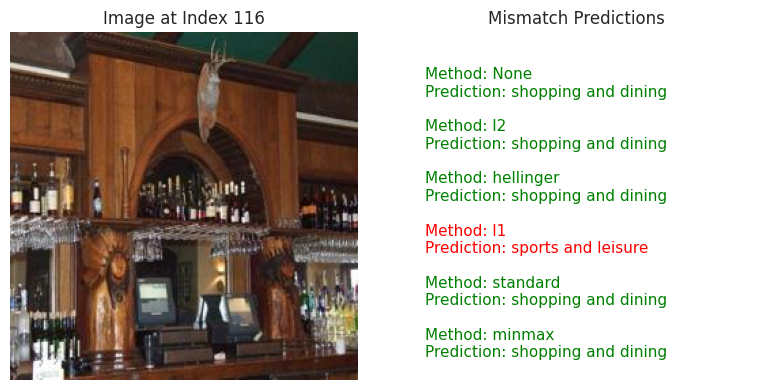

In [36]:
Secondary_All = np.stack([S1, S2, S3, S4, S5])

All_Secondary_Are_True = np.all(Secondary_All, axis=0)

Final_Mask = No_Method & (~All_Secondary_Are_True)
mismatch_indices = np.where(Final_Mask)[0]


plot_imgs_at_idx(mismatch_indices[25],data_test,methods,scaling_data)


Let's find one where we got it right and now we don't

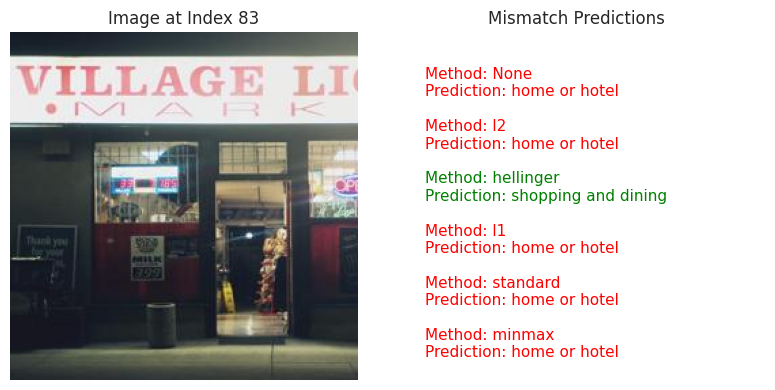

In [37]:
Any_Secondary_Is_True = np.any(Secondary_All, axis=0)

Primary_Is_False = ~No_Method

Final_Mask = Primary_Is_False & Any_Secondary_Is_True

mismatch_indices = np.where(Final_Mask)[0]

plot_imgs_at_idx(mismatch_indices[29],data_test,methods,scaling_data)


Now all true

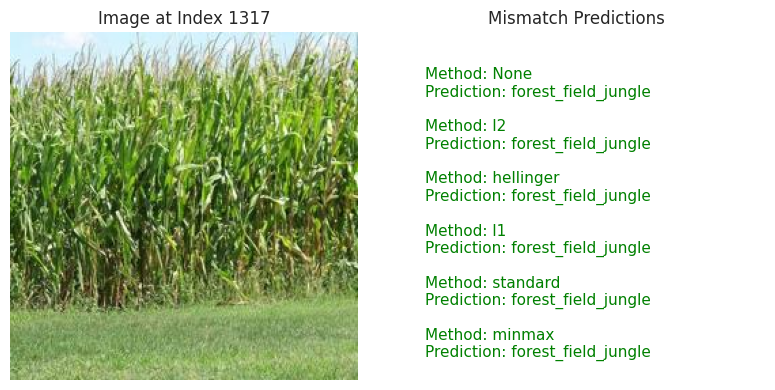

In [38]:
All_Secondary_Are_True = np.all(Secondary_All, axis=0)

Final_Mask = No_Method & All_Secondary_Are_True

mismatch_indices = np.where(Final_Mask)[0]

plot_imgs_at_idx(mismatch_indices[150],data_test,methods,scaling_data)


Now all false

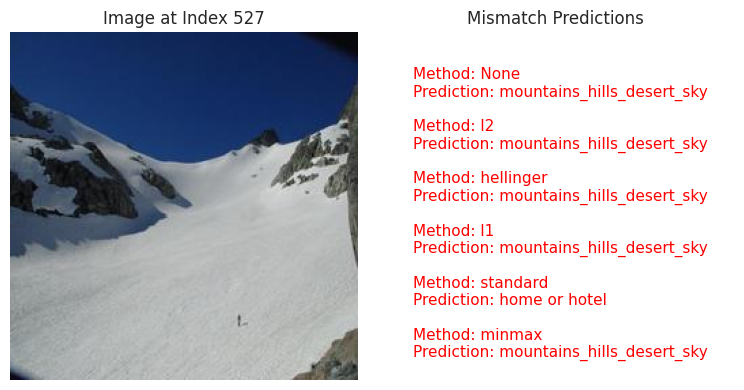

In [39]:
Not_P = ~No_Method
Not_S1 = ~S1
Not_S2 = ~S2
Not_S3 = ~S3
Not_S4 = ~S4
Not_S5 = ~S5

All_False_Arrays = np.stack([Not_P, Not_S1, Not_S2, Not_S3, Not_S4, Not_S5])


Final_Mask = np.all(All_False_Arrays, axis=0)
mismatch_indices = np.where(Final_Mask)[0]
plot_imgs_at_idx(mismatch_indices[200],data_test,methods,scaling_data)


In [75]:
numeric_columns = ['Train_Accuracy', 'CV_Accuracy', 'CV_Std', 'Test_Accuracy']
for col in numeric_columns:
    if col in results.columns:
        results[col] = pd.to_numeric(results[col], errors='coerce')

scaling = results[results["Experiment"] == "Scaling"].copy()


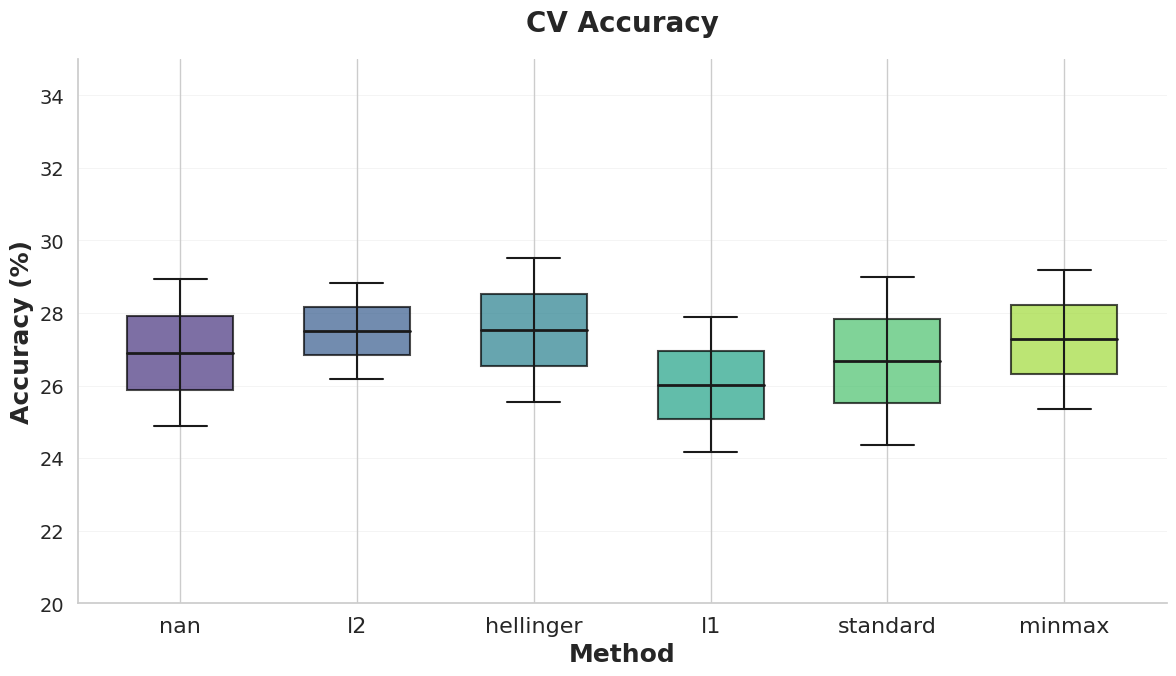

In [76]:

box_plot(scaling)

#### Classifier experiment

In [85]:
classifiers = ["log_reg", "svm_linear", "svm_rbf", "rf"]
experiment_one_acc = {}
experiment_one_data = {}

for clf in classifiers:
    print("Running classifier", clf)
    bovw = BOVW(detector_type="SIFT", codebook_size=128)
    experiment_one_acc[clf], experiment_one_data[clf] = run_BOVW_experiment(bovw,data_train,data_test, clf_name=clf)

clear_output()
print("Experiment classifiers succesfull")

Experiment classifiers succesfull


In [77]:
classifier_results = results[results["Experiment"] == "Classifiers"]
classifier_results

Experiment Parameter       Value  Classifier  Train_Accuracy  CV_Accuracy  \
1  Classifiers      Type     log_reg     log_reg        0.363417     0.284545   
2  Classifiers      Type  svm_linear  svm_linear        0.349851     0.271095   
3  Classifiers      Type     svm_rbf     svm_rbf        0.596114     0.301675   
4  Classifiers      Type          rf          rf        1.000000     0.247870   

     CV_Std  Test_Accuracy  
1  0.022446       0.303182  
2  0.011908       0.291818  
3  0.017618       0.340000  
4  0.013414       0.272727

/home/msiau/workspace/project-1/Week1/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Value'] = data['Value'].astype(str)


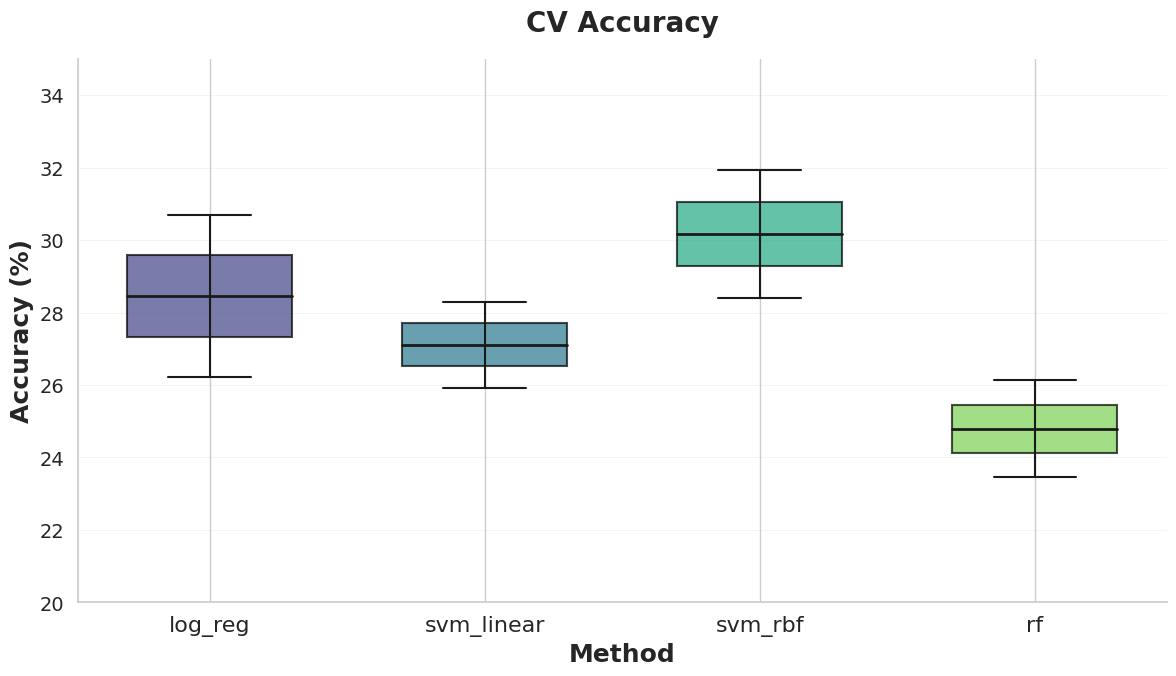

In [78]:
box_plot(classifier_results)

#### Experiment pyramids

In [81]:
pyramid_acc = {}
pyramid_data = {}
levels =  [1,2,3,4,5]
for lvl in levels:
        bovw = BOVW(detector_type="DENSE_SIFT", codebook_size=128, pyramid_levels=lvl,detector_kwargs={'step_size': 10, 'scales': [4, 8, 12, 16]})
        pyramid_acc[lvl], pyramid_data[lvl] = run_BOVW_experiment(bovw,data_train,data_test,)


clear_output()
print("Experiment pyramids succesfull")

Experiment pyramids succesfull


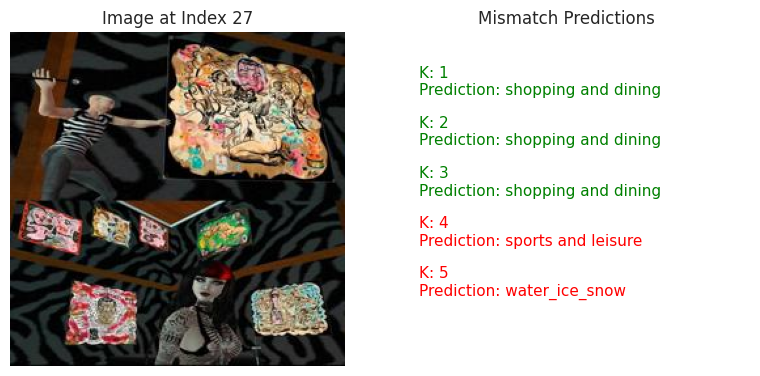

In [86]:



plot_imgs_at_idx(27,data_test,levels,pyramid_data)

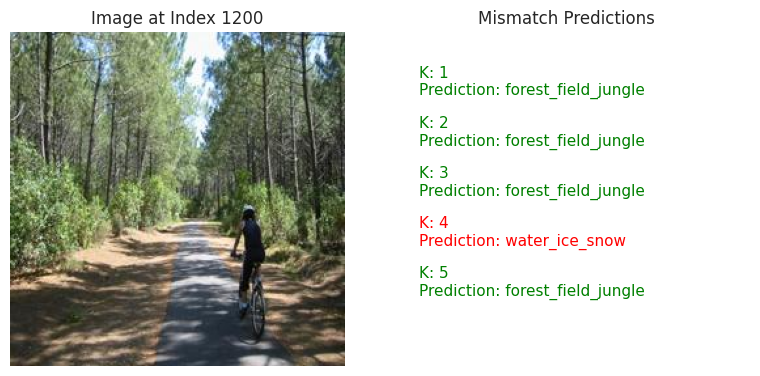

In [87]:


plot_imgs_at_idx(1200,data_test,levels,pyramid_data)

In [82]:
pyramid_results = results[results["Experiment"] == "Spatial Pyramid"]
pyramid_results

Experiment Parameter Value  Classifier  Train_Accuracy  CV_Accuracy  \
33  Spatial Pyramid    Levels     1  svm_linear        0.385747     0.300575   
34  Spatial Pyramid    Levels     2  svm_linear        0.512759     0.287011   
35  Spatial Pyramid    Levels     3  svm_linear        0.791494     0.254368   
36  Spatial Pyramid    Levels     4  svm_linear        0.995402     0.228966   
37  Spatial Pyramid    Levels     5  svm_linear        1.000000     0.239655   

      CV_Std  Test_Accuracy  
33  0.008701       0.340909  
34  0.014857       0.343636  
35  0.011112       0.303636  
36  0.005638       0.263182  
37  0.014180       0.276364

/home/msiau/workspace/project-1/Week1/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Value'] = data['Value'].astype(str)


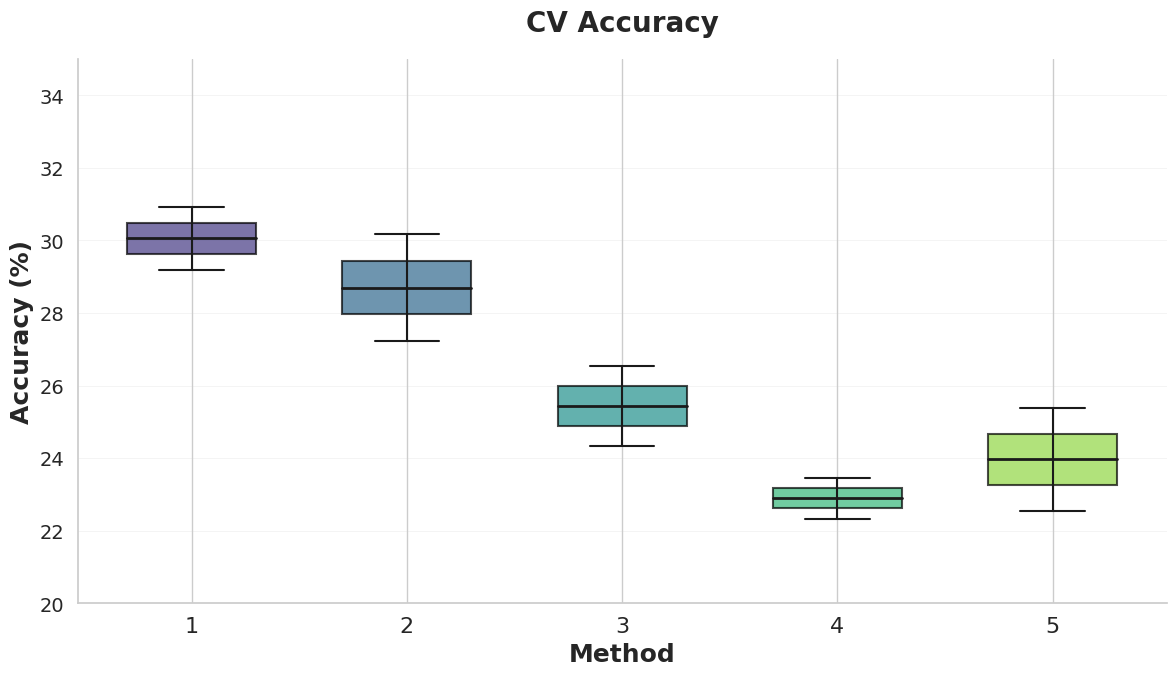

In [83]:
box_plot(pyramid_results)

Comparing Original Baseline, Our Baseline, And our final model

In [43]:

# Our Baseline
bovw = BOVW(detector_type="SIFT", codebook_size=128)
baselina_acc, baselina_data = run_BOVW_experiment(bovw,data_train,data_test, clf_name="svm_linear")

clear_output()

In [44]:
# Original 

bovw = BOVW()
og_acc, og_data = run_BOVW_experiment(bovw,data_train,data_test,)

clear_output()

In [42]:
from fisher_vector import final_mod3

final_acc2, final_data2 = final_mod3(data_train,data_test)

Gathering descriptors from training set (this may take a while)...


Extracting descriptors: 100%|██████████| 8700/8700 [01:49<00:00, 79.24it/s] 


Total train images with descriptors: 8700
Sample descriptors shape (for GMM): (200000, 128)
(200000, 128)
y
Fitting GMM with K=128, cov_type=diag on 200000 descriptors...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
Initialization converged: True


Computing Fisher Vectors (Parallel): 100%|██████████| 8700/8700 [01:12<00:00, 120.69it/s]


Extracting descriptors for test set...


Computing Fisher Vectors (Parallel): 100%|██████████| 2200/2200 [00:11<00:00, 194.75it/s]


Cross-validating on training FVs (5-fold)...
(8700, 32768)
CV accuracy: 0.4234 ± 0.0032
Fitted
Predicted


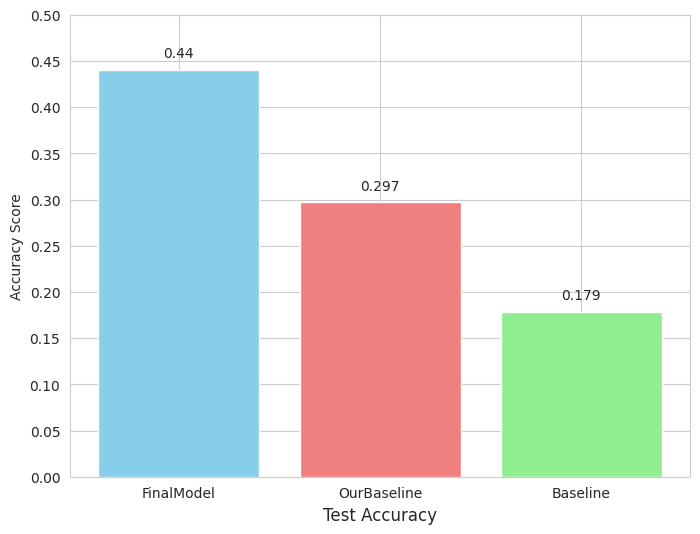

In [46]:
data = {
    'label': ['Baseline', 'OurBaseline', 'FinalModel'],
    'accuracy': [og_acc, baselina_acc, final_acc2]
}
df = pd.DataFrame(data)

df = df.sort_values(by='accuracy', ascending=False)

plt.figure(figsize=(8, 6))
bars = plt.bar(df['label'], df['accuracy'], color=['skyblue', 'lightcoral', 'lightgreen'])

plt.xlabel('Test Accuracy', fontsize=12)
plt.ylabel('Accuracy Score')

plt.ylim(0, 0.5)
plt.yticks(np.arange(0, 0.51, 0.05))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=10)

plt.show()

#### Extra plots


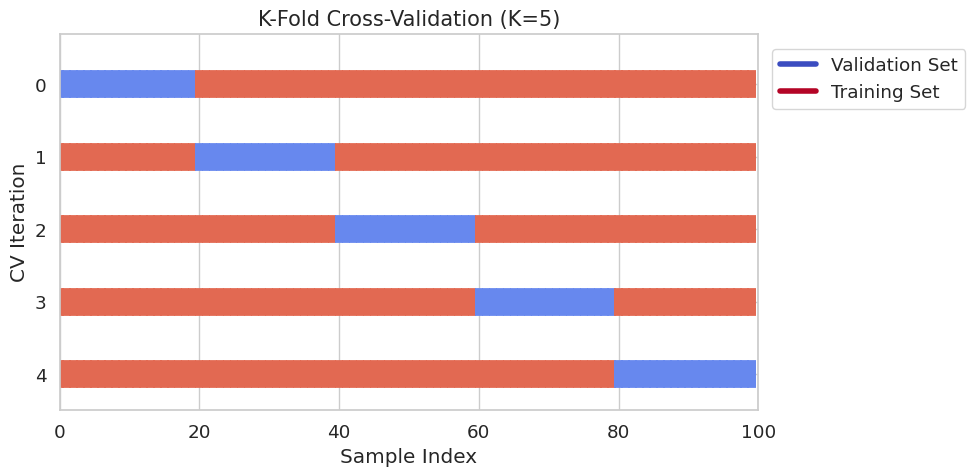

In [84]:
from sklearn.model_selection import KFold

def plot_cv_indices(cv, X, ax, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tr] = 1 
        indices[tt] = 0 

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(5))
    ax.set(yticks=np.arange(5) + .5, yticklabels=yticklabels,
           xlabel='Sample Index', ylabel="CV Iteration",
           ylim=[5, -.2], xlim=[0, 100])
    ax.set_title('K-Fold Cross-Validation (K=5)', fontsize=15)
    return ax

# 1. Create Dummy Data (just indices)
n_points = 100
X = np.random.randn(n_points, 10)
cv = KFold(n_splits=5)

# 2. Plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_cv_indices(cv, X, ax, lw=20)

ax.legend([plt.Line2D([0], [0], color=plt.cm.coolwarm(0.), lw=4),
           plt.Line2D([0], [0], color=plt.cm.coolwarm(1.), lw=4)],
          ['Validation Set', 'Training Set'], loc=(1.02, .8))
plt.tight_layout()
plt.show()